In [1]:
import mido
from midiutil.MidiFile import MIDIFile
import matplotlib
import pandas as pd
import string
import os
import sys
import pandas as pd
import IPython.display as ipd
import librosa.display
import pretty_midi
from matplotlib import pyplot as plt
import numpy as np


In [13]:
def postprocessing(arr2):
  x=arr2.shape[0]
  arr3 = np.zeros((88,x,2), dtype=int)
    #Array to store the start and end times of each note played in key 
  start=1
  k=0 
  for j in range(arr2.shape[1]):
     for i in range(arr2.shape[0]):
          if arr2[i,j]==1 and start==1:
              arr3[j,k,0]=i
              start=0
          elif arr2[i,j]==0 and start==0:
              arr3[j,k,1]=i
              start=1
              k+=1
     k=0

  #Array to store the end times of each key 
  arr4=np.zeros((88), dtype=int)
  for i in range(arr3.shape[0]):
    for j in range(arr3.shape[1]):
      if arr3[i,j,0]==0:
        arr4[i]=j
        break
  return[arr3,arr4]




In [107]:
midi_data = pretty_midi.PrettyMIDI("/mnt/d/MAPS/test/MUS/MAPS_MUS-bor_ps6_ENSTDkCl.mid")

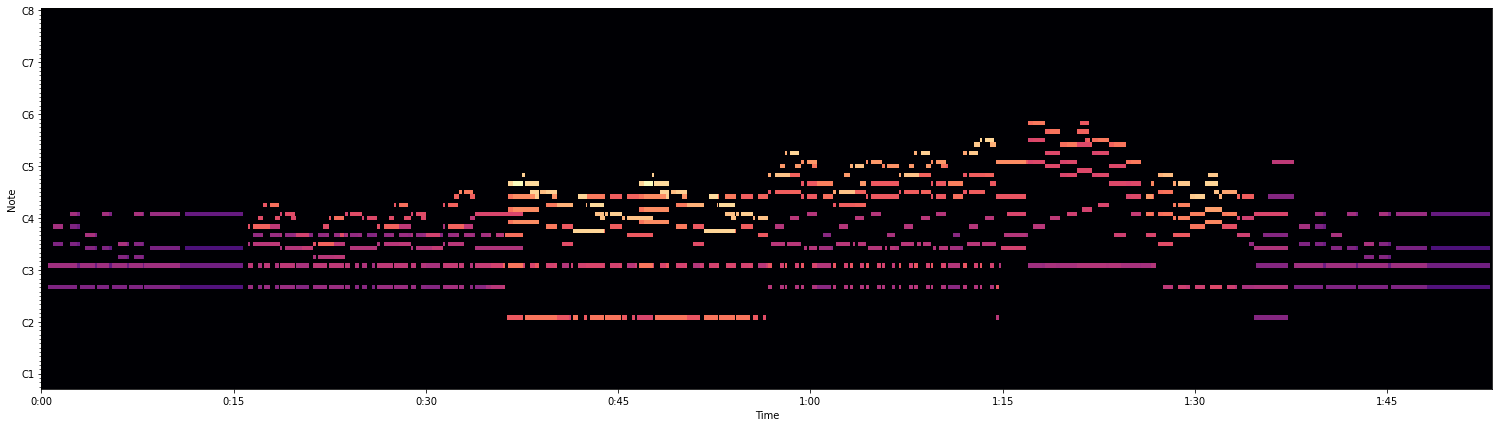

In [18]:
def plot_piano_roll(pm, start_pitch, end_pitch, sr=16000):
    librosa.display.specshow(pm.get_piano_roll(sr)[start_pitch:end_pitch],
                             hop_length=1, sr=sr, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch),fmax=pretty_midi.note_number_to_hz(end_pitch))
pm = pretty_midi.PrettyMIDI('/mnt/d/MAPS/test/MUS/MAPS_MUS-bor_ps6_ENSTDkCl.mid')
plt.figure(figsize=(26, 7))
plot_piano_roll(pm,21,109,10)

In [4]:
from keras.models import load_model

In [22]:
rnn=load_model('Saved_Model.h5')

In [6]:
xtest1=np.load("testingCQT.npy")

In [7]:
xtest1=np.reshape(xtest1,(xtest1.shape[0]//100,100,252))

In [8]:
rnn_predictions = rnn.predict(xtest1, batch_size=1, verbose = 1) 
#Now reshape Predictions back to 2D form.
rnn_predictions = np.reshape(rnn_predictions,(xtest1.shape[0]*xtest1.shape[1],88))

rnn_predictions = np.array(rnn_predictions).round()
#Convert all the values greater than 1 to 1.
rnn_predictions[rnn_predictions > 1] = 1

4/4 [==============================] - 9s 44ms/step


In [16]:
def arr_to_midi(source_array,duration_array):
  mf = MIDIFile(1,deinterleave=False)
  track = 0   
  time = 0
  channel = 0
  volume = 30
  delta = 0.03125
  mf.addTrackName(track, time, "Output3")
  mf.addTempo(track, time, 60)

  for i in range(source_array.shape[0]):
    for j in range(duration_array[i]):
              pitch = i + 21
              time = delta*source_array[i,j,0]
              duration = delta*( source_array[i,j,1] - source_array[i,j,0] ) 
              mf.addNote(track, channel, pitch, time, duration, volume)
  with open("Output3.mid", 'wb') as outf:
    mf.writeFile(outf)
  return mf

In [14]:
arr5,arr6=postprocessing(rnn_predictions)

In [17]:
mf=arr_to_midi(arr5,arr6)

In [100]:
print(arr6)

[  0   0   0   0   0   0   0   0   0   0   0  20   0   0   0   0  51   0
   0   0  10   5   0  51   0   0   2   0 115   0  14   0  49   0   2 111
   0  30   9  24 122   0  28   0  54  27   0  31   2  22   2   1  11   0
   9   1  11  10   0   9   0   2   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [101]:
midi_data1 = pretty_midi.PrettyMIDI("Output3.mid")

/mnt/c/Users/Himanshu/jupyter/environment/lib/python3.8/site-packages/librosa/display.py:1335: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  warnings.warn(


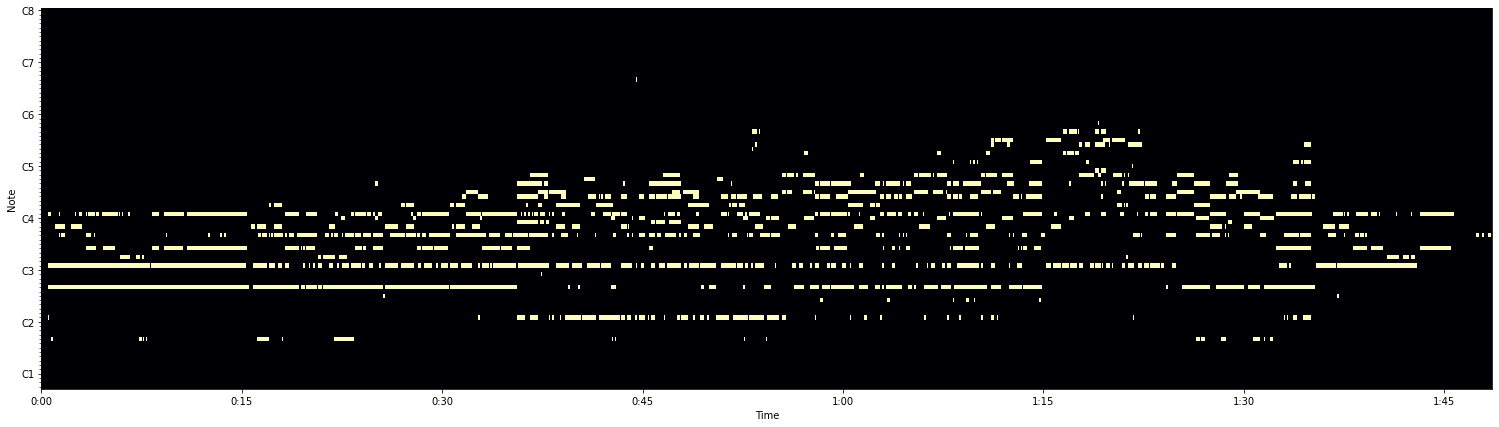

In [102]:
plt.figure(figsize=(26, 7))
plot_piano_roll(midi_data1,21,109,10)

In [103]:
midi_list = []
for instrument in midi_data1.instruments:
    for note in instrument.notes:
        start = note.start
        end = note.end
        pitch = note.pitch
        velocity = note.velocity
        midi_list.append([start, end, pitch, velocity, instrument.name])
              
    midi_list = sorted(midi_list, key=lambda x: (x[0], x[2]))

df = pd.DataFrame(midi_list, columns=['Start', 'End', 'Pitch', 'Velocity', 'Instrument'])
print(df)

         Start        End  Pitch  Velocity Instrument
0      0.53125    0.62500     37       100    Output2
1      0.53125    6.25000     49       100    Output2
2      0.56250   15.53125     44       100    Output2
3      0.59375    0.62500     61       100    Output2
4      0.65625    0.75000     61       100    Output2
..         ...        ...    ...       ...        ...
826  107.40625  107.65625     56       100    Output2
827  107.84375  108.06250     56       100    Output2
828  108.37500  108.50000     56       100    Output2
829  108.53125  108.56250     56       100    Output2
830  108.62500  108.65625     56       100    Output2

[831 rows x 5 columns]


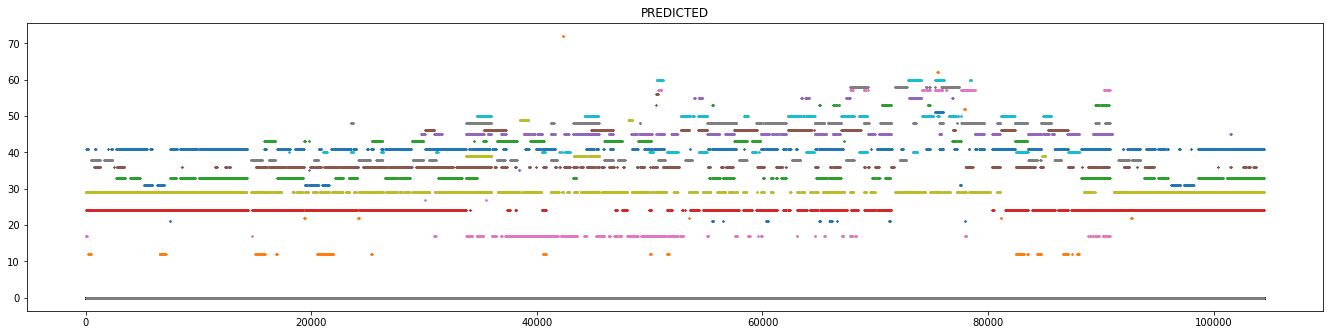

In [104]:
plot_colour_graph("output2.mid", "PREDICTED")